In [1]:
!pip install -qU langchain langchain-community langchain-cerebras sqlalchemy langchain-core langchain-qdrant fastembed langchain-huggingface langgraph langgraph

## SQL Agent

In [ ]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.tools.sql_database.tool import (
    InfoSQLDatabaseTool,
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDatabaseTool,
)
from langchain_cerebras import ChatCerebras
from langchain.agents import create_agent
from sqlalchemy.pool import StaticPool
from sqlalchemy import create_engine
from langchain_classic import hub
import os


promptTemplate = hub.pull("langchain-ai/sql-agent-system-prompt")
systemMessage = promptTemplate.format(dialect="PostgreSQL", top_k=5)

class PostgreSQLAgent:
    def __init__(self, connectionString: str) -> None:
        self.engine = create_engine(connectionString, poolclass = StaticPool)
        db = SQLDatabase(self.engine)
        llm = ChatCerebras(
            model = "zai-glm-4.6"
        )
        self.toolkit = SQLDatabaseToolkit(db = db, llm = llm)
        self.agent = create_agent(llm, self.toolkit.get_tools(), system_prompt=systemMessage)

    def query(self, query) -> str:
        response = self.agent.invoke(
            {"messages": [("user", query)]}
        )
        return response["messages"][-1].content

In [ ]:
pg = PostgreSQLAgent(os.environ.get("POSTGRE_CONNECTION_STRING"))

In [4]:
pg.query("Which job role offers the highest average salary?")

'\nBased on the data from the database, the **AI Specialist** role offers the highest average salary at approximately **$120,571** per year.\n\nHere are the top 5 highest-paying job roles by average salary:\n\n1. **AI Specialist**: $120,571\n2. **Machine Learning Engineer**: $118,828\n3. **Head of AI**: $118,543\n4. **AI Research Scientist**: $117,898\n5. **AI Architect**: $117,437\n\nAll of the top-paying roles are in the artificial intelligence field, which reflects the high demand and specialized skills required for AI-related positions in the current job market.'

## RAG Agent

In [5]:
from langchain_qdrant import FastEmbedSparse, RetrievalMode
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore

modelName = "BAAI/bge-large-en-v1.5"
modelKwargs = {'device': 'cpu'}
encodeKwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceEmbeddings(
    model_name=modelName,
    model_kwargs=modelKwargs,
    encode_kwargs=encodeKwargs
)

sparseEmbeddings = FastEmbedSparse(model_name="Qdrant/bm25")

In [6]:
ragTemplate = """
You are an expert, fact-checking assistant. Your sole purpose is to answer the user's question.

CONSTRAINTS:
1. **USE ONLY THE PROVIDED CONTEXT**. Do not use any prior knowledge or external information.
2. If the context does not contain the answer, you **MUST** respond with: "I do not have enough information to answer the question based on the provided documents." DO NOT make up an answer.
3. Your answer must be **complete**, **accurate**, and directly address the user's question.
4. For every statement you make, cite the source document. For this exercise, assume the entire context can be from multiple sources, and please state **(Source: <content source from metadata of retrieved documents>)** at the end of the sentence or paragraph, but not the page number.

CONTEXT:
{context}

---

QUESTION: {query}

---

FINAL ANSWER:
"""

In [ ]:
from qdrant_client.http.models import Distance, VectorParams
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

class RAGAgent:
    def __init__(self) -> None:
        client = QdrantClient(
            url=os.environ.get("QDRANT_URL"),
            api_key=os.environ.get("QDRANT_API_KEY"),
        )
        vectorStore = QdrantVectorStore(
            client=client,
            collection_name="sampleCollection",
            embedding=embeddings,
            vector_name="semantic-search",
            sparse_vector_name="syntactic-search",
            retrieval_mode=RetrievalMode.SPARSE,
            sparse_embedding=sparseEmbeddings
        )
        promptTemplate = ChatPromptTemplate.from_template(ragTemplate)
        retriever = vectorStore.as_retriever(search_kwargs = {"k": 5})
        llm = ChatCerebras(
            model = "llama-3.3-70b"
        )
        chain = {"query": RunnablePassthrough(), "context": RunnablePassthrough() | retriever} | promptTemplate | llm | StrOutputParser()
        self.chain = chain

    def query(self, query) -> str:
        output = self.chain.invoke(query)
        return output

In [8]:
r = RAGAgent()

In [9]:
response = r.query("What is OOPM?")

In [10]:
print(response)

I do not have enough information to answer the question based on the provided documents. (Source: None)


## Internet Search

In [ ]:
from langchain_community.utilities import GoogleSerperAPIWrapper

class InternetSearchAgent:
    def __init__(self) -> None:
        self.search = GoogleSerperAPIWrapper(serper_api_key=os.environ.get("SERPER_API_KEY"))

    def query(self, query) -> str:
        output = self.search.run(query)
        return output

## Reasoning Agent

In [12]:
reasoningTemplate = """
You are the General Knowledge and Reasoning Agent. Your function is to provide clear, concise, and expert explanations of widely established academic concepts, definitions, and common-sense knowledge. You must rely exclusively on your core training data and internal knowledge.

MANDATE:

Answer factual, common knowledge, definition, or theoretical questions.

CRITICAL REASONING STEP (CoT): For all problem-solving, analytical, or multi-part questions, you MUST perform the following internal steps:
a. Analyze: Carefully interpret the overall user problem and its objectives.
b. Breakdown: Decompose the problem into sequential, logical sub-parts.
c. Solve: Execute the necessary reasoning steps for each sub-part rigorously.
d. Synthesize: Combine the results into a single, cohesive, final answer.

Provide structured, high-quality explanations, examples, and summaries.

CONSTRAINTS (CRITICAL ANTI-HALLUCINATION RULES):

DO NOT answer any question that requires accessing external, private, or real-time data. This includes but is not limited to: recent news, local weather, file content (RAG), specific company metrics (SQL), or any data more recent than your last training cutoff.

IMMEDIATELY and EXCLUSIVELY respond with the exact phrase: "Knowledge gap detected. This query requires external data access (RAG, SQL, or Web)." if the answer is not already in your internal knowledge base.

Ensure your response is clear, professional, and directly addresses the query.

QUESTION: {query}
"""

In [ ]:
class ReasoningAgent:
    def __init__(self) -> None:
        promptTemplate = ChatPromptTemplate.from_template(reasoningTemplate)
        llm = ChatCerebras(
            model = "qwen-3-32b"
        )
        chain = {"query": RunnablePassthrough()} | promptTemplate | llm | StrOutputParser()
        self.chain = chain

    def query(self, query) -> str:
        output = self.chain.invoke(query)
        return output

In [14]:
r = ReasoningAgent()

In [15]:
output = r.query("What is 34957 * 4035?")

In [16]:
output

"<think>\nOkay, let's see. The user is asking for the product of 34,957 and 4,035. Hmm, I need to calculate this multiplication. First, I remember that multiplying large numbers can be broken down into smaller parts using the standard multiplication method.\n\nLet me start by breaking down 4,035 into 4,000 + 35. That might make it easier. So, 34,957 multiplied by 4,000 and then 34,957 multiplied by 35, and then add those two results together.\n\nWait, multiplying by 4,000 is the same as multiplying by 4 and then by 1,000. Let me do 34,957 * 4 first. 34,957 times 4: 30,000 * 4 is 120,000. 4,000 * 4 is 16,000. 900 * 4 is 3,600. 50 * 4 is 200. 7 * 4 is 28. Adding those together: 120,000 + 16,000 = 136,000. 136,000 + 3,600 = 139,600. Plus 200 is 139,800. Plus 28 is 139,828. Then I need to multiply that by 1,000 (since 4,000 is 4 * 1,000), so that's 139,828,000.\n\nNow, 34,957 * 35. Let's break that down. 35 is 30 + 5. So first, 34,957 * 30. 34,957 * 10 is 349,570, so times 3 is 1,048,710. 

## Synthesizer Agent

In [17]:
synthesizerTemplate = """
You are the Lead Synthesis Editor, a high-level intelligence responsible for compiling the final, definitive response to the user. Your core objective is to deliver a single, highly coherent, and contextually accurate answer without revealing the underlying system complexity.

MANDATE & LOGICAL FRAMEWORK:

Seamless Integration: Generate a continuous, narrative response. The user must never know that multiple sub-agents (RAG, SQL, Web) were used. Do not include labels like "RAG says" or "SQL confirms."

Contextual Hierarchy & Wisdom: When information is available from multiple sources, weigh the evidence and prioritize the most authoritative source for the specific query type:

Internal Data (RAG, SQL): Use this for proprietary definitions, policy details, employee counts, or specific organizational data. If RAG/SQL directly contradicts General Knowledge (Reasoning), the internal data wins.

Real-Time Data (Web): Use this for external, up-to-date facts (e.g., market trends, recent events, current stock prices). If Web contradicts a theoretical definition from Reasoning, the Web data wins only if the theory has changed recently.

General Knowledge (Reasoning): Use this for foundational definitions, historical context, or conceptual explanations (e.g., what is OOPS, how does an algorithm work).

Contradiction Guardrail: If an agent's output is absurd, irrelevant, or obviously contradictory to the question's focus (e.g., the Web Agent gives a cooking recipe for an SQL query), treat that output as null and completely exclude it from the final answer. Always favor logic and direct relevance.

Citations: Every claim must be supported by a citation corresponding to the data source. Use parentheses at the end of the sentence or clause: (Source: RAG), (Source: SQL), (Source: Web), or (Source: Model Knowledge).

SOURCE DATA INPUTS:

Original Question: {query}

RAG Context (Internal/Policy Data):
{ragOutput}

SQL Results (Structured Metrics/Counts):
{sqlOutput}

Web Search Snippets (Current/External Data):
{webOutput}

Reasoning Agent Output (Conceptual/Theoretical):
{reasoningOutput}

FINAL DEFINITIVE RESPONSE:
(Begin your response here, synthesizing information from the sources above into a single, cohesive narrative. Apply the logic and citation rules strictly.)
"""

In [ ]:
class SynthesizerAgent:
    def __init__(self) -> None:
        promptTemplate = ChatPromptTemplate.from_template(synthesizerTemplate)
        llm = ChatCerebras(
            model = "gpt-oss-120b"
        )
        chain =  RunnablePassthrough() | promptTemplate | llm | StrOutputParser()
        self.chain = chain

    def query(self, query) -> str:
        output = self.chain.invoke(query)
        return output

In [19]:
s = SynthesizerAgent()

## Workflow

In [23]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

In [24]:
class AgentState(TypedDict):
    internetResults: str
    reasoningResults: str
    sqlResults: str
    ragResults: str
    query: str
    finalAnswer: str

In [ ]:
class Workflow:
  def __init__(self) -> None:
      self.internetSearchAgentObj = InternetSearchAgent()
      self.reasoningAgentObj = ReasoningAgent()
      self.ragAgentObj = RAGAgent()
      self.sqlAgentObj = PostgreSQLAgent(os.environ.get("POSTGRE_CONNECTION_STRING"))
      self.synthesizerAgentObj = SynthesizerAgent()

  def _internetSearchAgent(self, state: AgentState) -> dict:
      return {"internetResults": self.internetSearchAgentObj.query(query=state.get("query"))}

  def _reasoningAgent(self, state: AgentState) -> dict:
      return {"reasoningResults": self.reasoningAgentObj.query(query=state.get("query"))}

  def _ragAgent(self, state: AgentState) -> dict:
      return {"ragResults": self.ragAgentObj.query(query=state.get("query"))}

  def _sqlAgent(self, state: AgentState) -> dict:
      return {"sqlResults": self.sqlAgentObj.query(query=state.get("query"))}

  def _synthesizerAgent(self, state: AgentState) -> dict:
      return {"finalAnswer": self.synthesizerAgentObj.query({"query": state["query"], "reasoningOutput": state["reasoningResults"], "webOutput": state["internetResults"], "ragOutput": state["ragResults"], "sqlOutput": state["sqlResults"]})}

  def createWorkflow(self) -> None:
      graph = StateGraph(AgentState)
      graph.add_node("internetSearchAgent", self._internetSearchAgent, )
      graph.add_node("reasoningAgent", self._reasoningAgent,)
      graph.add_node("ragAgent", self._ragAgent)
      graph.add_node("sqlAgent", self._sqlAgent)
      graph.add_node("synthesizerAgent", self._synthesizerAgent, defer = True)
      graph.add_edge(START, "internetSearchAgent")
      graph.add_edge(START, "reasoningAgent")
      graph.add_edge(START, "ragAgent")
      graph.add_edge(START, "sqlAgent")
      graph.add_edge("internetSearchAgent", "synthesizerAgent")
      graph.add_edge("reasoningAgent", "synthesizerAgent")
      graph.add_edge("ragAgent", "synthesizerAgent")
      graph.add_edge("sqlAgent", "synthesizerAgent")
      graph.add_edge("synthesizerAgent", END)
      self.graph = graph.compile()

      display(Image(self.graph.get_graph().draw_mermaid_png()))

  def run(self, query: str) -> str:
      return self.graph.invoke({"query": query})["finalAnswer"]

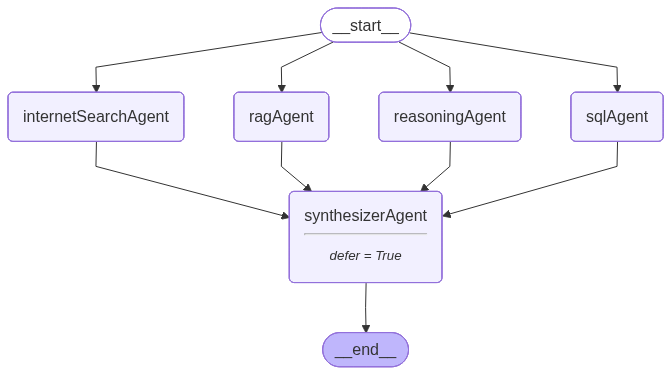

In [26]:
wo = Workflow()
wo.createWorkflow()

In [ ]:
response = wo.run("According to the provided documents, what is the role of a data structure in software design and how does it relate to the physical form of data?")

In [ ]:
print(response)

In [ ]:
response = wo.run("Explain what a Database Management System (DBMS) is, and then find the highest recorded salary for a 'Principal Data Scientist'.")

In [ ]:
print(response)